In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import copy
import matplotlib.pyplot as plt
from ncn import NashCascadeNetwork as ncn
from ncn import train_model as train_ncnn
import matplotlib.font_manager as font_manager
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
PRECIP_SVN_SEQ = "atmosphere_water__liquid_equivalent_precipitation_rate_seq"
PRECIP_RECORD = "atmosphere_water__liquid_equivalent_precipitation_rate_record"
DO_PLOT = True
N_TIMESTEPS = 300

In [3]:
network_precip_input_list = []
count = 0
unit_precip = 6.0
for i in range(N_TIMESTEPS):

    ###########################################################################
    if count == 0:
        network_precip_input_list.append(1.0)
    elif count > 45:
        network_precip_input_list.append(unit_precip)
    else:
        network_precip_input_list.append(0.0)
    if count == 50:
        count = 0
    count+=1
    ###########################################################################
network_precip_tensor = torch.tensor(network_precip_input_list, requires_grad=False)
total_mass_precip_in = torch.sum(network_precip_tensor)

In [4]:
# Example 0
bucket_net = ncn(cfg_file="./config_0.json")
bucket_net.initialize()
bucket_net.unit_precip = unit_precip
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.tensor([tensor.item() for tensor in bucket_net.sum_H_per_layer]))
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_0 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=False))
    bucket_net.update()
    network_outflow_list_0.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

network_outflow_tensor_0 = torch.tensor(network_outflow_list_0, requires_grad=True)
bucket_net.report_out_mass_balance()
bucket_net.detach_ncn_from_graph()
bucket_net.theta.detach()


Initial Mass in network at start: 20.0
Initial Mass in network: 20.0
Final Mass in network: 21.9
Total Mass out of network 173.1
Total precipitation into network 175.0
Mass balance for network is -0.000
Mass balance for network is -0.000


/home/jonat/nash_cascade_neural_network/ncn.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inflows_tensor = torch.tensor(inflows, dtype=torch.float32)  # Convert inflows to a tensor


tensor([0.2547, 0.2705, 0.1567, 0.2007, 0.2382])

In [5]:
# Example 1
bucket_nn = ncn(cfg_file="./config_1.json")
bucket_nn.initialize()
bucket_nn.unit_precip = unit_precip
print("Initialized")
bucket_nn.initialize_theta_values()
inital_mass_in_network = torch.sum(torch.stack(bucket_nn.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1a = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_nn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    if bucket_nn.do_predict_theta_with_lstm:
        sequence_tensors = []
        tensor_device = bucket_nn.network[0]['H'].device
        tensor_dtype = torch.float32
        if i >= bucket_nn.input_u_sequence_length:
            sequence_tensors = [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                for item in network_precip_input_list[i-bucket_nn.input_u_sequence_length:i]]
        else:
            desired_tensor_shape = (1,)
            padding_size = bucket_nn.input_u_sequence_length - i
            padding_tensors = [torch.zeros(desired_tensor_shape, device=tensor_device, dtype=tensor_dtype) 
                            for _ in range(padding_size)]
            sequence_tensors = padding_tensors + [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                                for item in network_precip_input_list[:i]]
        sequence = torch.stack(sequence_tensors).view(1, -1)
        bucket_nn.set_value(PRECIP_SVN_SEQ, sequence)


    bucket_nn.update()
    network_outflow_list_1a.append(bucket_nn.network_outflow.item())
    bucket_nn.summarize_network()
    ###########################################################################
    ###########################################################################

###########################################################################
network_outflow_tensor_1 = torch.tensor(network_outflow_list_1a, requires_grad=True)
bucket_nn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.theta.detach())


Initialized
Initial Mass in network at start: 20.0
Initial Mass in network: 20.0
Final Mass in network: 15.3
Total Mass out of network 179.7
Total precipitation into network 175.0
Mass balance for network is -0.000
Mass balance for network is -0.000


In [6]:
bucket_nn.set_value(PRECIP_RECORD, torch.tensor(network_precip_input_list, requires_grad=False))
y_pred, loss = train_ncnn(bucket_nn, network_precip_tensor, network_outflow_tensor_0)
network_outflow_list_1b = list(y_pred.detach().numpy())
print(bucket_net.theta)
print(bucket_nn.theta)

Adjusting learning rate of group 0 to 5.0000e-01.
loss: 0.9531------------
theta: tensor([0.4536, 0.5511, 0.5276, 0.4700, 0.5238], grad_fn=<SelectBackward0>)
model.lstm_output.grad[-1][0]
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.1700])
Adjusting learning rate of group 0 to 5.0000e-01.
loss: 0.6110------------
theta: tensor([0.4541, 0.5484, 0.5269, 0.4638, 0.4152], grad_fn=<SelectBackward0>)
model.lstm_output.grad[-1][0]
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.1322])
Adjusting learning rate of group 0 to 5.0000e-01.
loss: 0.1302------------
theta: tensor([0.4538, 0.5477, 0.5278, 0.4550, 0.2643], grad_fn=<SelectBackward0>)
model.lstm_output.grad[-1][0]
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0635])
Adjusting learning rate of group 0 to 4.5000e-01.
loss: 0.0261------------
theta: tensor([0.4525, 0.5507, 0.5302, 0.4497, 0.1847], grad_fn=<SelectBackward0>)
model.lstm_output.grad[-1][0]
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0183])
Adjusting learning rate of group 0 to 4.5000e-01.
lo

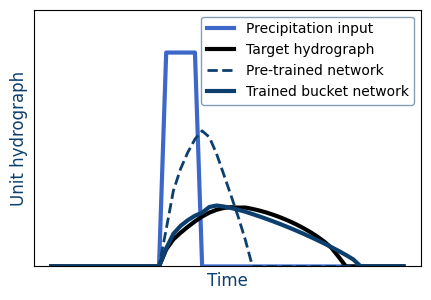

In [7]:
DO_PLOT = True
if DO_PLOT:
    startplt = 230
    endplt = 280
    bigfontsize = 12
    smallfontsize = 10
    # Set figure size to 7 inches wide
    figure_width = 5  # inches
    aspect_ratio = 3 / 2  # Adjust as needed for your plot
    figure_height = figure_width / aspect_ratio

    plt.figure(figsize=(figure_width, figure_height))

    # Set color
    light_blue_color = "#3D68CA"
    line_and_text_color = "#0D3F6E"

    # Plot each series with specified color
    plt.plot(network_precip_input_list[startplt:endplt], c=light_blue_color, lw=3, label="Precipitation input")
    plt.plot(network_outflow_list_0[startplt:endplt], c="k", lw=3, label="Target hydrograph ")
    plt.plot(network_outflow_list_1a[startplt:endplt], "--", lw=2, c=line_and_text_color, label="Pre-trained network")
    plt.plot(network_outflow_list_1b[startplt:endplt], lw=3, c=line_and_text_color, label="Trained bucket network")

    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value * 1.2])

    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Unit hydrograph", fontsize=bigfontsize, color=line_and_text_color)
    plt.xlabel("Time", fontsize=bigfontsize, color=line_and_text_color)

    # Modify legend to have a transparent background
    plt.legend(fontsize=smallfontsize, edgecolor=line_and_text_color, framealpha=0.5)  # Adjust framealpha as needed

#    plt.title("Flow out from network and precip", fontsize=bigfontsize, color=line_and_text_color)

    # Save the figure with transparent background and at 300 DPI
    plt.show()
    #plt.savefig("ncn_plot.png", transparent=True, dpi=300)

    plt.close()



In [8]:
bucket_net.network

{0: {'H': tensor([11.8430]),
  'S': tensor([[[0.4963, 0.7682],
           [0.0885, 0.1320]]]),
  's_q': tensor([[3.3728, 0.4440]])},
 1: {'H': tensor([7.5421, 0.3513]),
  'S': tensor([[[0.3074, 0.6341]],
  
          [[0.4901, 0.8964]]]),
  's_q': tensor([[1.2839],
          [0.4289]])},
 2: {'H': tensor([2.1219]),
  'S': tensor([[[0.4556, 0.6323]]]),
  's_q': tensor([[1.1111]])}}

In [9]:
bucket_nn.network

{0: {'H': tensor([6.2935]),
  'S': tensor([[[0.7576, 0.2793],
           [0.4031, 0.7347]]]),
  's_q': tensor([[1.8836, 3.9088]])},
 1: {'H': tensor([0.0000, 2.0025]),
  'S': tensor([[[0.0293, 0.7999]],
  
          [[0.3971, 0.7544]]]),
  's_q': tensor([[1.8836],
          [3.3220]])},
 2: {'H': tensor([12.4078]),
  'S': tensor([[[0.5695, 0.4388]]]),
  's_q': tensor([[1.2958]])}}

In [10]:
bucket_net.theta

tensor([0.2547, 0.2705, 0.1567, 0.2007, 0.2382], requires_grad=True)

In [11]:
bucket_nn.theta

tensor([0.4526, 0.5519, 0.5322, 0.4481, 0.1841], grad_fn=<SelectBackward0>)

In [12]:
origional_bucket_theta

tensor([0.4536, 0.5511, 0.5276, 0.4700, 0.5238])

In [13]:
torch.sum(bucket_nn.theta - origional_bucket_theta)

tensor(-0.3572, grad_fn=<SumBackward0>)

In [14]:
bucket_nn.theta - origional_bucket_theta

tensor([-0.0010,  0.0009,  0.0046, -0.0219, -0.3397], grad_fn=<SubBackward0>)

In [15]:
print(thislinewillstopthenotebookfromrunningthecellsbelow)

NameError: name 'thislinewillstopthenotebookfromrunningthecellsbelow' is not defined

tensor([0.4541, 0.5421, 0.5248, 0.4519, 0.2302], grad_fn=<SelectBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.5579])
tensor([0.4525, 0.5540, 0.5329, 0.4459, 0.1759], grad_fn=<SelectBackward0>)
tensor([ 6.3881,  0.0000,  2.4799, 16.4175])
Initial Mass in network: 20.0
Final Mass in network: 20.7
Total Mass out of network 9099.3
Total precipitation into network 9100.0
Mass balance for network is -0.017
Mass balance for network is -0.016


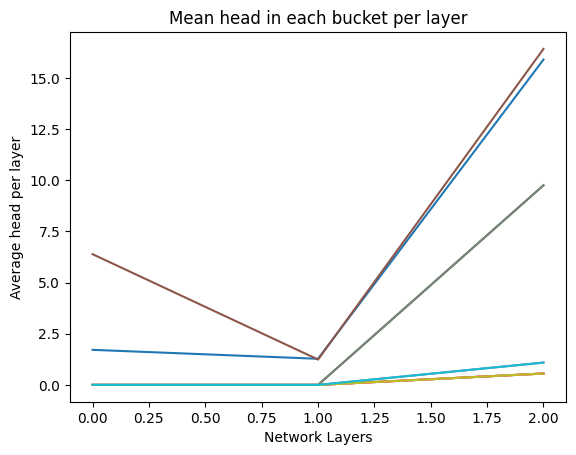

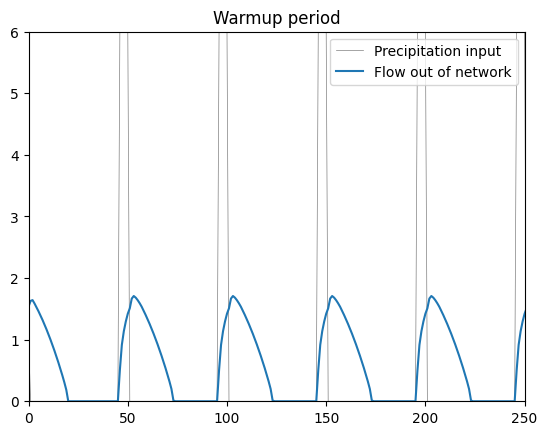

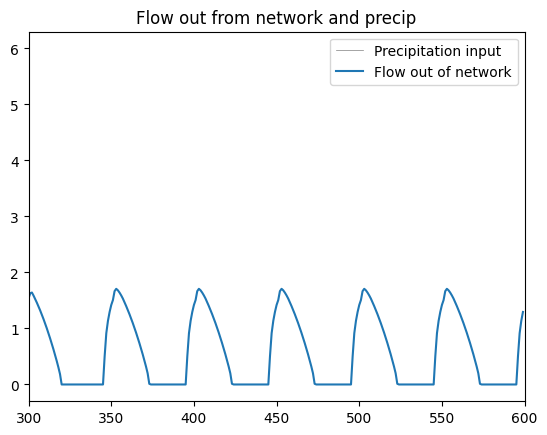

In [16]:
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_nn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    if bucket_nn.do_predict_theta_with_lstm:
        sequence_tensors = []
        tensor_device = bucket_nn.network[0]['H'].device
        tensor_dtype = torch.float32
        if i >= bucket_nn.input_u_sequence_length:
            sequence_tensors = [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                for item in network_precip_input_list[i-bucket_nn.input_u_sequence_length:i]]
        else:
            desired_tensor_shape = (1,)
            padding_size = bucket_nn.input_u_sequence_length - i
            padding_tensors = [torch.zeros(desired_tensor_shape, device=tensor_device, dtype=tensor_dtype) 
                            for _ in range(padding_size)]
            sequence_tensors = padding_tensors + [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                                for item in network_precip_input_list[:i]]
        sequence = torch.stack(sequence_tensors).view(1, -1)
        bucket_nn.set_value(PRECIP_SVN_SEQ, sequence)


    bucket_nn.update()
    network_outflow_list_1b.append(bucket_nn.network_outflow.item())
    bucket_nn.summarize_network()

    if i in [180, 200]:
        print(bucket_nn.theta)
        print(bucket_nn.get_the_H_tensor())
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_nn.mean_H_per_layer])

###########################################################################
network_outflow_tensor_1 = torch.tensor(network_outflow_list_1b, requires_grad=True)
bucket_nn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.theta.detach())

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1b, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1b)-(len(network_outflow_list_1b)/2))
    endplt = int(len(network_outflow_list_1b))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1b, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [ ]:
#print(thiscellwillstopthenotebookbeforethepureneuralnetworksaretrained)

In [17]:
import numpy as np
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'

Using CUDA device:  NVIDIA GeForce RTX 3090


/home/jonat/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 0.013962998986244202
epoch: 1 loss: 0.0021269929129630327
epoch: 2 loss: 0.005982712376862764
epoch: 3 loss: 0.004117697477340698
epoch: 4 loss: 0.0029096584767103195
Final loss: 0.0029096584767103195


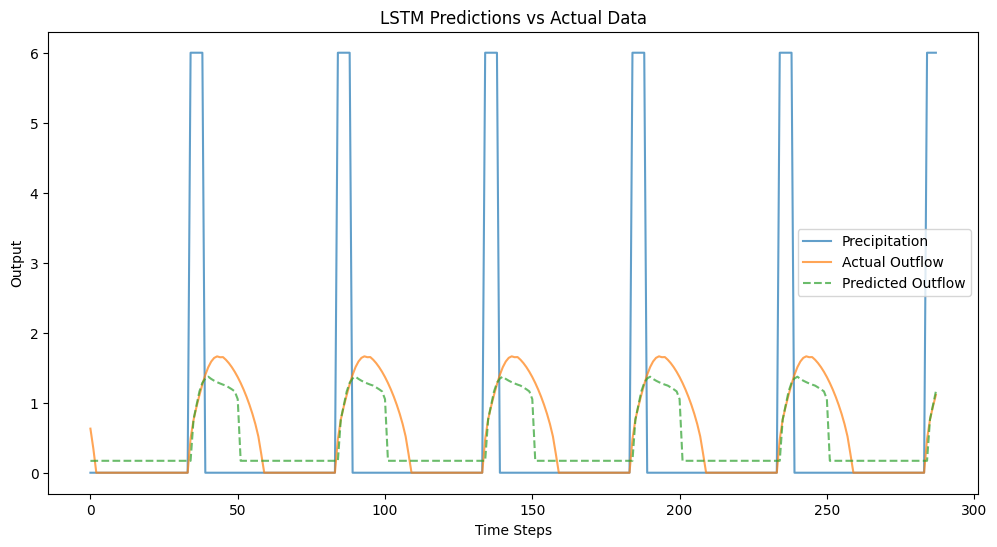

In [18]:
# Convert arrays to PyTorch tensors
x_input = torch.FloatTensor(network_precip_tensor.detach().numpy())
y_target = torch.FloatTensor(network_outflow_tensor_0.detach().numpy())

# Define the sequence length (you can adjust this)
seq_length = 12

# Function to create sequences
def create_sequences(input_data, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data)-seq_length):
        x_seq = input_data[i:i+seq_length]
        y_seq = target_data[i+seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return torch.stack(xs), torch.stack(ys)

X, y = create_sequences(x_input, y_target, seq_length)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=256, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

print(f'Final loss: {single_loss.item()}')




predictions = []
model.eval()
with torch.no_grad():
    for seq in X:
        predictions.append(model(seq).item())

# Convert predictions to a numpy array for easy plotting
predictions_np = np.array(predictions)
plt.figure(figsize=(12, 6))
plt.title("LSTM Predictions vs Actual Data")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
plt.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
plt.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
plt.legend()
plt.show()


In [19]:
# Convert arrays to PyTorch tensors
x_input = torch.FloatTensor(network_precip_tensor.detach().numpy())
y_target = torch.FloatTensor(network_outflow_tensor_0.detach().numpy())

# Define the sequence length (you can adjust this)
seq_length = 35

# Function to create sequences
def create_sequences(input_data, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x_seq = input_data[i:i + seq_length]
        y_seq = target_data[i + seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return torch.stack(xs), torch.stack(ys)

X, y = create_sequences(x_input, y_target, seq_length)

# Feedforward Neural Network Model
class FFNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=3, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define your feedforward layers here
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        self.activations = []
        x = self.fc1(input_seq)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.relu1(x)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.fc2(x)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.relu2(x)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.fc3(x)
        self.activations.append(x.detach().numpy())  # Record activation
        predictions = self.fc4(x)
        return predictions[-1]

model = FFNNModel(input_size=seq_length)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99, verbose=True)

epochs = 150
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    scheduler.step()
    if epoch % 1 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item():.4f}')

print(f'Final loss: {single_loss.item()}')

Adjusting learning rate of group 0 to 6.0000e-03.
Adjusting learning rate of group 0 to 5.9400e-03.
epoch: 0 loss: 0.5113
Adjusting learning rate of group 0 to 5.8806e-03.
epoch: 1 loss: 0.2596
Adjusting learning rate of group 0 to 5.8218e-03.
epoch: 2 loss: 0.7307
Adjusting learning rate of group 0 to 5.7636e-03.
epoch: 3 loss: 0.6566
Adjusting learning rate of group 0 to 5.7059e-03.
epoch: 4 loss: 0.2595
Adjusting learning rate of group 0 to 5.6489e-03.
epoch: 5 loss: 0.0056
Adjusting learning rate of group 0 to 5.5924e-03.
epoch: 6 loss: 0.3216
Adjusting learning rate of group 0 to 5.5365e-03.
epoch: 7 loss: 0.3558
Adjusting learning rate of group 0 to 5.4811e-03.
epoch: 8 loss: 0.2934
Adjusting learning rate of group 0 to 5.4263e-03.
epoch: 9 loss: 0.3570
Adjusting learning rate of group 0 to 5.3720e-03.
epoch: 10 loss: 0.4619
Adjusting learning rate of group 0 to 5.3183e-03.
epoch: 11 loss: 0.0951
Adjusting learning rate of group 0 to 5.2651e-03.
epoch: 12 loss: 0.2236
Adjusting l

In [20]:
x_input.shape, y_target.shape, predictions_np.shape

(torch.Size([300]), torch.Size([300]), (288,))

In [21]:
predictions = []
model.eval()
with torch.no_grad():
    for i, seq in enumerate(X):
        predictions.append(model(seq).item())
predictions_np = np.array(predictions)

DO_PLOT = True
if DO_PLOT:
    startplt = 230
    endplt = 280
    bigfontsize = 22
    smallfontsize = 16
    # Set figure size to 7 inches wide
    figure_width = 7  # inches
    aspect_ratio = 3 / 2  # Adjust as needed for your plot
    figure_height = figure_width / aspect_ratio

    plt.figure(figsize=(figure_width, figure_height))

    # Set color
    light_blue_color = "#3D68CA"
    line_and_text_color = "#0D3F6E"

    # Plot each series with specified color
    plt.plot(network_precip_input_list[startplt:endplt], c=light_blue_color, lw=10, label="Precipitation input")
    plt.plot(network_outflow_list_0[startplt:endplt], c="k", lw=10, label="Target hydrograph ")
    # plt.plot(network_outflow_list_1a[startplt:endplt], "--", lw=5, c=line_and_text_color, label="Pre-trained network")
    plt.plot(predictions_np[startplt-seq_length:endplt-seq_length], "--", lw=10, c=line_and_text_color, label="Trained bucket network")

    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value * 1.2])

    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Unit hydrograph", fontsize=bigfontsize, color=line_and_text_color)
    plt.xlabel("Time", fontsize=bigfontsize, color=line_and_text_color)

    # Modify legend to have a transparent background
    #plt.legend(fontsize=smallfontsize, edgecolor=line_and_text_color, framealpha=0.5)  # Adjust framealpha as needed

    #plt.title("Flow out from network and precip", fontsize=bigfontsize, color=line_and_text_color)

    # Save the figure with transparent background and at 300 DPI
    #plt.show()
    plt.savefig("./figs/ffn_plot.png", transparent=True, dpi=300)

    plt.close()

def plot_the_time_series(x_input, y_target, predictions_np, seq_length):
    plt.figure(figsize=(12, 6))
    plt.title("FFNN Predictions vs Actual Data")
    plt.xlabel("Time Steps")
    plt.ylabel("Output")
    plt.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
    plt.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
    plt.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
    plt.legend()
    plt.show()
    plt.close()
predictions = []
model.eval()
with torch.no_grad():
    for i, seq in enumerate(X):
        predictions.append(model(seq).item())
predictions_np = np.array(predictions)
plot_the_time_series(x_input, y_target, predictions_np, seq_length)

In [22]:
import imageio
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

In [23]:
#print(thiscellwillstopthenotebookbeforetheanimationismade)

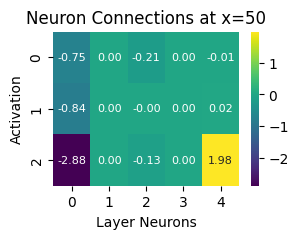

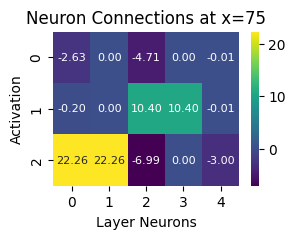

In [24]:
def visualize_layer_connections_with_annotations(model, input_seq, title):
    model(input_seq)  # Forward pass to record activations
    activations = model.activations

    # Concatenate activations horizontally
    concatenated_activations = np.hstack([activation.reshape(-1, 1) for activation in activations])

    # Plotting
    plt.figure(figsize=(3, 2))  # Adjust the figure size as needed
    ax = sns.heatmap(concatenated_activations, annot=True, fmt=".2f", cmap="viridis", annot_kws={"size": 8})
    plt.title(title)
    plt.xlabel("Layer Neurons")
    plt.ylabel("Activation")
    plt.show()

# Usage
for i in [50, 75]:
    visualize_layer_connections_with_annotations(model, X[i], f"Neuron Connections at x={i}")


In [25]:
def network_visualization_subplot(model, input_seq, layer_sizes, title, ax):
    model(input_seq)  # Forward pass to record activations
    activations = model.activations

    # Create a color map
    cmap = plt.get_cmap('viridis')

    # Normalize the activation values to [-5, 5] for the color map
    norm = mcolors.Normalize(vmin=-5, vmax=5)

    # Number of layers including input and output
    num_layers = len(layer_sizes)

    # List to store node positions, to be used to draw the edges
    node_positions = {}

    # Generate positions for each layer
    for i, size in enumerate(layer_sizes):
        # Vertical positions
        v_positions = np.linspace(0, 1, size + 2)[1:-1]

        # Horizontal position
        h_position = i / (num_layers - 1)

        # Draw nodes
        for j, v in enumerate(v_positions):
            activation = 0
            if i > 0:  # Skip input layer for activations
                activation = activations[i-1][j]
            color = cmap(norm(activation))

            circle = plt.Circle((h_position, v), 0.05, color=color, zorder=4)
            ax.add_artist(circle)
            node_positions[(i, j)] = (h_position, v)

            # Optionally, add activation values as text inside the nodes
            # plt.text(h_position, v, f'{activation:.2f}', ha='center', va='center', color='white', fontsize=8)

    # Draw edges
    for i in range(num_layers - 1):
        for j in range(layer_sizes[i]):
            for k in range(layer_sizes[i + 1]):
                start_pos = node_positions[(i, j)]
                end_pos = node_positions[(i + 1, k)]
                line = plt.Line2D([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], c='black', alpha=0.3)
                ax.add_line(line)

    mappable = ScalarMappable(norm=norm, cmap=cmap)

    # Add a colorbar
    plt.colorbar(mappable, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Set title and turn off axis
    ax.set_title(title)
    ax.axis('off')


In [26]:
def plot_the_time_series_subplot(x_input, y_target, predictions_np, seq_length, t, ax):
    ax.set_title("FFNN Predictions vs Actual Data")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Output")
    ax.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
    ax.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
    ax.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
    ax.axvline(x=t, color='red', linestyle='--')  # Vertical line
    ax.legend()

In [27]:
# Define the size of each layer (including input and output layers)
layer_sizes = [1, 3, 3, 3, 1]  # Example: input layer with 35 nodes, three hidden layers with 3 nodes each, and an output layer with 1 node

# Usage
for t in range(1,200):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Network visualization on the first subplot
    network_visualization_subplot(model, X[t], layer_sizes, f"Neural Network Visualization at t={t}", ax1)

    # Time series plot on the second subplot
    plot_the_time_series_subplot(x_input, y_target, predictions_np, seq_length, t, ax2)

    plt.tight_layout()
    plt.savefig(f"./figs/network_plot/combined_frame_{t}.png")
    plt.close(fig)

In [28]:
filenames = [f"./figs/network_plot/combined_frame_{t}.png" for t in range(1, 200)]
images = [imageio.imread(filename) for filename in filenames]
imageio.mimsave('network_animation.gif', images, fps=2)  # Adjust fps as needed

/tmp/ipykernel_2485/2658828076.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]
